### Main file

In [45]:
from tools.helpers import *
from tools.srbm import *
from tools.parameters import *
from brian2 import *
from brian2tools import *
import numpy as np
import matplotlib.pyplot as plt
import datetime

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]

In [3]:
Id = create_Id()
W, b_v, b_c, b_h = create_rbm_parameters()
mnist_data = load_mnist_data(min_p = .00001, max_p = .98, binary = True, seed=0)
loc = main(W, b_v, b_c, b_h, Id =create_Id(), monitors = True, mnist_data=mnist_data)
locals().update(loc)

Creating equation
Creating Population


INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


Train accuracy: 0.075
Test accuracy: 0.091
Train accuracy: 0.095
Test accuracy: 0.099
Train accuracy: 0.175
Test accuracy: 0.218
Train accuracy: 0.12
Test accuracy: 0.1
Train accuracy: 0.18
Test accuracy: 0.183
Train accuracy: 0.18
Test accuracy: 0.168
Train accuracy: 0.23
Test accuracy: 0.194
Train accuracy: 0.265
Test accuracy: 0.256
Train accuracy: 0.145
Test accuracy: 0.167
Train accuracy: 0.165
Test accuracy: 0.197
Train accuracy: 0.195
Test accuracy: 0.188
Train accuracy: 0.09
Test accuracy: 0.097
Train accuracy: 0.185
Test accuracy: 0.178
Train accuracy: 0.185
Test accuracy: 0.171
Train accuracy: 0.18
Test accuracy: 0.168
Train accuracy: 0.18
Test accuracy: 0.163
Train accuracy: 0.14
Test accuracy: 0.137
Train accuracy: 0.115
Test accuracy: 0.12
Train accuracy: 0.145
Test accuracy: 0.159
Train accuracy: 0.205
Test accuracy: 0.223
Train accuracy: 0.15
Test accuracy: 0.172
Train accuracy: 0.26
Test accuracy: 0.214
Train accuracy: 0.13
Test accuracy: 0.137
Train accuracy: 0.195
Tes

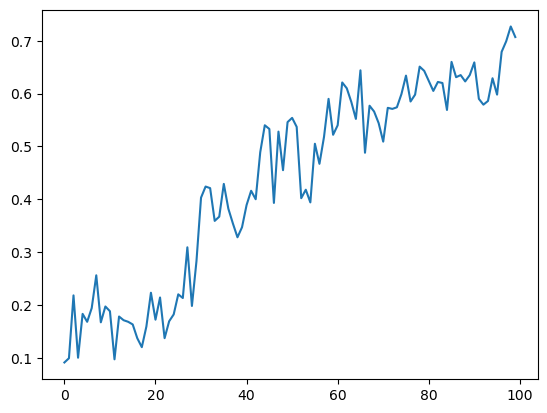

In [23]:
plot(res_hist_test)
plt.show()

In [58]:
# Why does beta get replaced by the numpy function??

beta = 2.04371561e+09

mypath = "output/"+date_str
if not os.path.isdir(mypath):
   os.makedirs(mypath)

W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta
W.dump("output/"+date_str+"/W_"+date_time_str+".dat")

Wvh=W[:N_v,:]
Wvh.dump("output/"+date_str+"/Wvh_"+date_time_str+".dat")

Wch=W[N_v:,:]
Wch.dump("output/"+date_str+"/Wch_"+date_time_str+".dat")

mBv = np.array(Sbv.w)*beta*tau_rec*bias_input_rate
mBv.dump("output/"+date_str+"/mBv_"+date_time_str+".dat")

mBh = np.array(Sbh.w)*beta*tau_rec*bias_input_rate
mBh.dump("output/"+date_str+"/mBh_"+date_time_str+".dat")

b_c = mBv[N_v:(N_v+N_c)]
b_c.dump("output/"+date_str+"/b_c_"+date_time_str+".dat")

b_v = mBv[:N_v]
b_v.dump("output/"+date_str+"/b_v_"+date_time_str+".dat")

b_h = mBh
b_h.dump("output/"+date_str+"/b_h_"+date_time_str+".dat")

mB = np.concatenate([mBv,mBh])
mB.dump("output/"+date_str+"/mB_"+date_time_str+".dat")